### pre-process the CFSv2 hindcasts ... 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime, timedelta

In [3]:
import pygrib
import numpy as np
import pandas as pd

In [4]:
import xarray as xr; print(xr.__version__)

0.14.0


In [5]:
# xr.set_options(display_style="html")

In [6]:
import dask

In [7]:
client = dask.distributed.Client()

In [8]:
from dask.diagnostics import ProgressBar

In [9]:
client

Client Scheduler: tcp://127.0.0.1:38125 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 134.95 GB


In [10]:
import os

In [11]:
import pathlib

In [12]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [13]:
prov = 'IRI'

In [14]:
var_name = 'T2M'

In [12]:
dict_var_names = {}
dict_var_names['T2M'] = ('tref','t2m')

In [15]:
model = 'CFSv2'

In [16]:
dpath = pathlib.Path(f'/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/{prov}/{model}/{var_name}/')

In [17]:
lfiles = list(dpath.glob("*.nc"))

In [18]:
def sf(x): 
    x = x.name 
    x = x.split('_')[-2] + x.split('_')[-1].split('.nc')[0].zfill(2) + '01'
    return int(x)

In [19]:
def sfdates(x): 
    from datetime import datetime
    x = x.name 
    d = datetime(int(x.split('_')[-2]), int(x.split('_')[-1].split('.nc')[0]), 1)
    return d

In [20]:
lfiles.sort(key=sf)

In [21]:
len(lfiles)

348

In [22]:
print(lfiles[0])

/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/IRI/CFSv2/T2M/CFSv2_hindcasts_T2M_1982_1.nc


In [23]:
print(lfiles[-1])

/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/IRI/CFSv2/T2M/CFSv2_hindcasts_T2M_2010_12.nc


In [24]:
year_start = 1982

In [25]:
year_end = 2010

In [ ]:
dset_concat = []
for y in range(year_start+1, year_end + 1): 
    lfiles_y  = list(dpath.glob(f"*{var_name}_{y}_*.nc"))
    lfiles_y.sort(key=sf)
    ### read with mfdataset (needs dask installed )
    dset = xr.open_mfdataset(lfiles_y, concat_dim='time', parallel=True, engine='h5netcdf')
    dates = np.array([sfdates(x) for x in lfiles_y])
    dset['time'] = (('time'), dates)
    dset = dset.rename({'leadtime':'step'})
    dset['step'] -= 0.5
    dset = dset.chunk({'time':12, 'step':10, 'member':4, 'lat':10, 'lon':10})
    ### calculates the rolling averages over the `step` dimension 
    dset_rm = dset.rolling({'step':3}, min_periods=3).mean()
    ### selects from step (leadtime) 3 onwards 
    dset_rm = dset_rm.sel(step=slice(3,5))
    ### creates a variable `forecast_valid_time` which varies along the dimension time and step and contains the forecast validity dates 
    lt_arr = []
    for t in dset_rm.time.data: 
        lt = np.array([pd.to_datetime(t) + relativedelta(months=3), \
                       pd.to_datetime(t) + relativedelta(months=4), \
                       pd.to_datetime(t) + relativedelta(months=5)])
        lt_arr.append(lt)
    lt_arr = np.array(lt_arr)
    dset_rm['forecast_valid_time'] = (('time','step'), lt_arr)
    
    dset_rm.rename({dict_var_names[var_name][0]:dict_var_names[var_name][1]})
    
    filename_out = f"{var_name.upper()}_hindcasts_{y}_{model}_seasonal.nc"
    
    dset_rm_delayed = dset_rm.to_netcdf(f'../../data/GCMs_temp/{filename_out}', compute=False)
    
    with ProgressBar():
        results = dset_rm_delayed.compute()
    dset_concat.append(dset_rm)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
distributed.comm.tcp - WARNING - Closing d

### check the units ==> Kelvin for tref / T2M

In [10]:
dset = xr.open_dataset('../../data/GCMs_temp/T2M_hindcasts_1982_CFSv2_seasonal.nc') 

In [11]:
dset 

<xarray.Dataset>
Dimensions:              (lat: 181, lon: 360, member: 24, step: 3, time: 12)
Coordinates:
  * lat                  (lat) float32 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * member               (member) float32 1.0 2.0 3.0 4.0 ... 22.0 23.0 24.0
  * step                 (step) float32 3.0 4.0 5.0
  * lon                  (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time                 (time) datetime64[ns] 1982-01-01 ... 1982-12-01
Data variables:
    tref                 (time, step, member, lat, lon) float32 ...
    forecast_valid_time  (time, step) datetime64[ns] ...

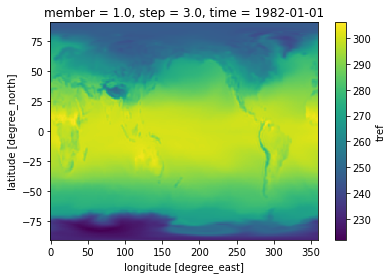

In [13]:
dset.tref[0,0,0,:,:].plot()

In [ ]:
# dset_rm.to_netcdf(dpath / filename_out)

### now calculates the anomalies with respect to the 1981 - 2010 period 

In [ ]:
def demean(x): 
    return x - x.sel(time=slice('1981','2010')).mean('time')

In [ ]:
anoms_rm = dset_rm.groupby('time.month').apply(demean)

In [ ]:
anoms_rm['forecast_valid_time'] = (('time','step'), dset_rm.forecast_valid_time)

In [ ]:
anoms_rm

In [ ]:
filename_out = f"{var.upper()}_hindcasts_{yearstart}_{yearend}_{model}_seasonal_anomalies.nc"

In [ ]:
filename_out

In [ ]:
anoms_rm.to_netcdf(dpath / filename_out)

In [ ]:
anoms_rm

In [ ]:
anoms_rm.sel(time='1997-12-01').sel(step=3).mean('member')['precip'].plot()